<a href="https://colab.research.google.com/github/Dworlock11/Exoplanet-Machine-Learning-Analysis/blob/main/Exoplanet_Habitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This project intends to create machine learning models for predicting an exoplanet's type (Terran, Jovian, etc.) and mass. In addition, the most significant predictive features of these characteristics will be found and analyzed. There will be two groups of models: a classification group for predicting the type of exoplanet and a regression group for predicting the mass. Various models will be trained, tested, and evaluated, and the best model from each group will be determined. Both the performance and the time necessary for training will be considered when determining the best models.



# Import Statements

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error,
                             root_mean_squared_error)
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

# Exploratory Data Analysis and Preprocessing

The data from an Excel sheet is read into a DataFrame.

In [305]:
df = pd.read_excel("Exoplanet Catalog.xlsx")
pd.set_option("display.max_columns", None)
df

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,P_ATMOSPHERE,S_NAME,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_METALLICITY,S_METALLICITY_ERROR_MIN,S_METALLICITY_ERROR_MAX,S_MASS,S_MASS_ERROR_MIN,S_MASS_ERROR_MAX,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TYPE,S_AGE,S_AGE_ERROR_MIN,S_AGE_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_DISC,S_MAGNETIC_FIELD,S_LOG_G,S_ALT_NAMES,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,P_TYPE,S_RADIUS_EST,S_TYPE_TEMP,S_RA_H,S_RA_T,S_DEC_T,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007.0,2014-05-14,326.030000,-0.320,0.320,1.29000,-0.050,0.050,0.231,-0.005,0.005,NaN,NaN,NaN,94.8,-1.5,1.5,2452899.6,-1.6,1.6,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 Com,185.179280,17.792868,4.740,93.37,-1.92,1.92,-0.35,-0.09,0.09,2.70,-0.300,0.300,19.000000,-2.000,2.000,K0 III,NaN,NaN,NaN,4742.0,-100.0,100.0,NaN,NaN,2.31,"HD 107383, HIP 60202",NaN,NaN,NaN,NaN,0.130671,1.324418,0.99201,1.58799,1.298759,101.011410,64.855456,166.191940,799.44963,722.98875,914.73942,Jovian,19.000000,K,12.345286,12 20 43.0286,+17 47 34.3248,163.546800,10.132812,24.763411,12.834754,23.477907,13.586847,23.477907,12.390643,23.477907,34.529063,0.476460,0.642400,0.0,0.0,Hot,0.0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009.0,2018-09-06,516.219970,-3.200,3.200,1.53000,-0.070,0.070,0.080,-0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 UMi,229.274540,71.823898,5.016,125.72,-1.97,1.97,-0.02,NaN,NaN,2.78,-0.690,0.690,29.790000,-2.840,2.840,K4 III,NaN,NaN,NaN,4213.0,-46.0,46.0,NaN,NaN,1.93,"HD 136726, HIP 74793",NaN,NaN,NaN,NaN,0.167551,1.534896,1.40760,1.65240,1.531227,107.351180,91.741348,126.426170,819.07569,788.47184,854.28770,Jovian,29.790000,K,15.284970,15 17 05.8915,+71 49 26.0328,250.492940,12.770059,31.984271,16.175280,30.323783,17.134143,30.323783,15.615215,30.323783,42.732816,0.193891,0.648683,0.0,0.0,Hot,0.0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008.0,2014-05-14,185.840000,-0.230,0.230,0.83000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2452861.4,-1.5,1.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,14 And,352.822570,39.236198,5.227,75.59,-0.71,0.71,-0.24,-0.03,0.03,2.20,-0.200,0.100,11.000000,-1.000,1.000,G8 III,NaN,NaN,NaN,4813.0,-20.0,20.0,NaN,NaN,2.63,"HD 221345, HIP 116076",NaN,NaN,NaN,NaN,0.073485,0.830000,0.83000,0.83000,0.830000,84.446427,84.446427,84.446427,772.30746,772.30746,772.30746,Jovian,11.000000,G,23.521506,23 31 17.4215,+39 14 10.3128,58.175144,6.025230,14.680087,7.631867,13.918028,8.078404,13.918028,7.367780,13.918028,20.593611,0.502752,0.600010,0.0,0.0,Hot,0.0,0.081917,Andromeda,And,And

Before the data can be used for model development, it needs to be cleaned and analyzed. Firstly, as many of the columns from the dataset contain a lot of null entries, it is best to simply remove the columns. All columns with more null values than a quarter of the number of rows in the dataset are removed.

In [306]:
col_non_null_count = df.isna().sum()
cols_non_majority_null = col_non_null_count[col_non_null_count < len(df)/4].index.to_list()
df = df[cols_non_majority_null]

Additional feature selection is conducted, as many of the features are unhelpful for model training, are copies of one another, or are highly correlated.

In [307]:
df = df.drop(["P_NAME", "P_STATUS", "P_RADIUS", "P_YEAR", "P_UPDATED", "S_NAME", "S_RADIUS", "S_ALT_NAMES", "P_HABZONE_OPT", "P_HABZONE_CON", "S_CONSTELLATION_ABR", "P_PERIOD_ERROR_MIN", "P_PERIOD_ERROR_MAX", "S_DISTANCE_ERROR_MIN", "S_DISTANCE_ERROR_MAX", "P_FLUX_MIN", "P_FLUX_MAX", "P_TEMP_EQUIL_MIN", "P_TEMP_EQUIL_MAX"], axis=1)

Categorical features with far too many unique values are removed to simplify feature encoding.

In [308]:
# Find categorical features
cat_features = df.select_dtypes(exclude=np.number)

# Number of null values per feature
for col in cat_features.columns:
  print(col, "-", len(cat_features[col].value_counts()))

# Drop features with too many null values
df = df.drop(["S_RA_T", "S_DEC_T", "S_CONSTELLATION", "S_CONSTELLATION_ENG"], axis=1)

P_DETECTION - 10
P_TYPE - 6
S_TYPE_TEMP - 7
S_RA_T - 3010
S_DEC_T - 3010
P_TYPE_TEMP - 3
S_CONSTELLATION - 88
S_CONSTELLATION_ENG - 88


The data is checked for the skew of each feature to determine the appropriate imputing method for numerical data.

In [309]:
np.abs(df.skew(axis=0, numeric_only=True, skipna=True)).sort_values(ascending=False)

,0
P_PERIOD,62.170001
P_FLUX,45.699102
S_MASS_ERROR_MAX,45.649624
S_ABIO_ZONE,39.242821
S_RADIUS_ERROR_MIN,32.113850
S_RADIUS_ERROR_MAX,31.053663
P_PERIASTRON,28.463444
P_SEMI_MAJOR_AXIS_EST,28.395487
P_DISTANCE_EFF,28.376942
P_DISTANCE,28.337572


Since the data is heavily skewed, the median will be chosen.

The distribution of exoplanet type is observed.

In [310]:
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,58
Miniterran,1


A single Miniterran planet can't be split amongst a training and test set. However, if the Miniterran in the data has a radius close to that of Subterrans, it would be appropriate to mask it as one.

In [311]:
miniterran = df[df["P_TYPE"] == "Miniterran"]
print("Miniterran mass:", miniterran["P_RADIUS_EST"].iloc[0])

subterran = df[df["P_TYPE"] == "Subterran"]
print("Smallest Subterran mass:", subterran["P_RADIUS_EST"].min())

Miniterran mass: 0.33394605
Smallest Subterran mass: 0.40356


Indeed, the radius is around 0.33 times that of Earth, which isn't too far in value from the lightest Subterran. Therefore, the planet is masked as one.

In [312]:
df["P_TYPE"] = df["P_TYPE"].mask(df["P_TYPE"] == "Miniterran", "Subterran")
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,59


Now, the distribution of exoplanet mass is observed.

In [313]:
df["P_MASS_EST"].describe()

,P_MASS_EST
count,4048.000000
mean,323.089993
std,965.084290
min,0.000000
25%,3.628101
50%,7.815324
75%,149.379160
max,17668.059000


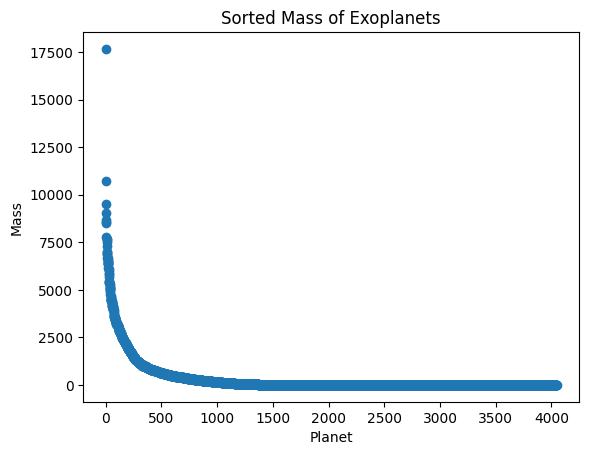

In [314]:
plt.scatter(x=range(0, len(df.index)), y=df["P_MASS_EST"].sort_values(ascending=False))
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Sorted Mass of Exoplanets")
plt.show()

From this distribution, a couple of points should be made:
*   The median exoplanet seems to be approximately eight times the mass of the Earth. A minority are singificantly larger. There will almost certainly be a significant difference between the RMSE and the MAE when evaluating the models, since RMSE is more sensitive to outliers.
*   Because the smallest planets and the largest are orders of magnitude apart, it would make sense to tranform the mass into log space. This tranformed feature will be stored in a copy of the dataset.
*   Huber loss will be used for hyperparameter training and permutation in order to balance the majority of small planets with the minority of massive ones. A manual definition is created, since no built-in one is available in the version of sci-kit learn used in this project.
*   It's not clear what exactly it means for a planet to have a mass of 0.0. It might be a mistake. Such entries will be removed to be safe.

In [315]:
# Define Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)

    quadratic = np.minimum(abs_error, delta)
    linear = abs_error - quadratic

    return np.mean(0.5 * quadratic**2 + delta * linear)

# Create scorer
huber_scorer = make_scorer(huber_loss, greater_is_better=False, delta=1.0)

# Remove entries with 0 masses
df = df[df["P_MASS_EST"] != 0.0]

# Copy data and transform mass into logspace
log_df = df.copy()
log_df["Log_Mass"] = np.log10(log_df["P_MASS_EST"])
log_df = log_df.drop("P_MASS_EST", axis=1)

All rows where the target value is null, if any, are removed to prevent errors.

In [316]:
# Remove null entries in the type column and display number of null entries
print("Number of null values in type column:", df["P_TYPE"].isna().sum())
type_na = df[df["P_TYPE"].isna()].index
df = df.drop(type_na)
print("Number of null values after removal:", df["P_TYPE"].isna().sum(), "\n")

# Remove null entries in the mass column and display number of null entries
print("Number of null values in mass column:", log_df["Log_Mass"].isna().sum())
mass_na = log_df[log_df["P_TYPE"].isna()].index
log_df = log_df.drop(mass_na)
print("Number of null values after removal:", log_df["P_TYPE"].isna().sum())

Number of null values in type column: 1
Number of null values after removal: 0 

Number of null values in mass column: 1
Number of null values after removal: 0


Now, model development can begin.

# Exoplanet Type Classification

The classification models will be trained first, starting with logistic regression.

## Logistic Regression

The data is separated into the features and the target.

In [317]:
X = df.drop("P_TYPE", axis=1)
y = df["P_TYPE"]

The data is split into the training and testing data. It is stratified by the exoplanet type to make sure that a proportional number of each type is present in both the training set and the test set.

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

The data preprocessor is created, including data imputing, standardizing, and encoding.

In [319]:
# Find numerical and categorical columns
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Create transformer for numerical columns
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Create transformer for categorical columns
linear_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", feature_name_combiner="concat"))
])

# Combine transformers
log_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("linear_cat_transformer", linear_cat_transformer, cat_col_names)
])

The pipeline is created and the hyperparameter C is tuned to prevent overfitting.

In [320]:
log_pipe = Pipeline([
    ("log_preprocessor", log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}

search = RandomizedSearchCV(log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is now trained and the tuned values for each hyperparameter are displayed.

In [321]:
# Supress convergence warnings
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)

best_model = search.best_estimator_

print("C:", f"{search.best_params_["log_reg__C"]:.3f}")

C: 372.759


The model is tested and evaluated.

In [322]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.97      0.98       260
   Neptunian       0.94      0.94      0.94       180
   Subterran       0.58      0.58      0.58        12
 Superterran       0.96      0.97      0.96       220
      Terran       0.94      0.94      0.94       135

    accuracy                           0.95       807
   macro avg       0.88      0.88      0.88       807
weighted avg       0.95      0.95      0.95       807



The model performs very well overall. Interestingly, Subterrans performed significantly worse than the other types, likely due to a much smaller number of entries in the dataset. A confusion matrix illustrates these findings.

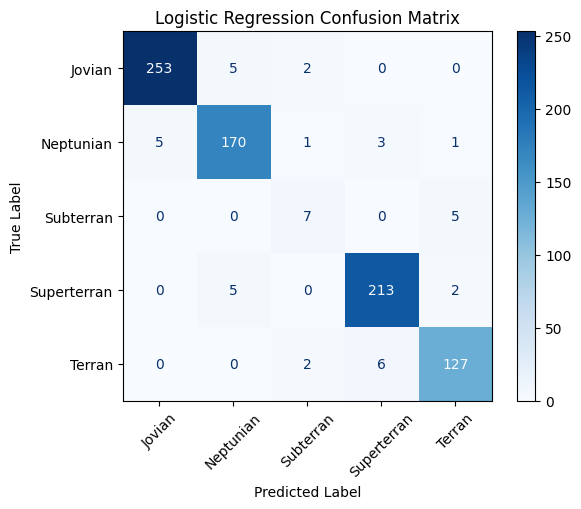

In [323]:
class_labels = ["Jovian", "Neptunian", "Subterran", "Superterran", "Terran"]

cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

Permutation is used to find the importance of the individual features. It will be used across all models for standardized results. The test set must be manually transformed with all preprocessing steps before implementing permutation to match the number of columns present after feature encoding.

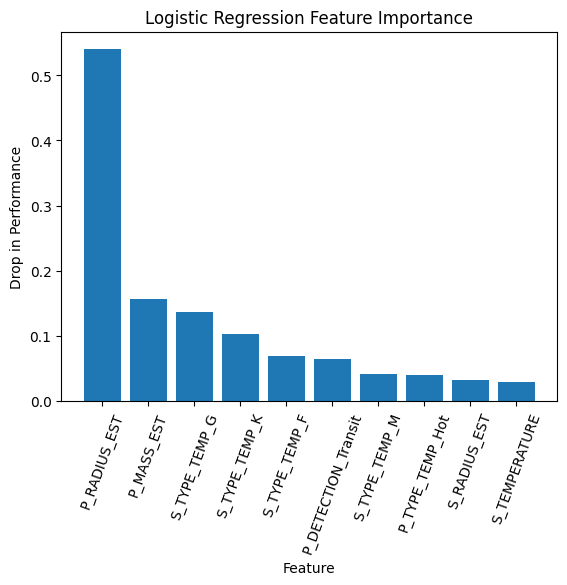

In [324]:
# Extract components
preprocessor = best_model.named_steps["log_preprocessor"]
log_reg = best_model.named_steps["log_reg"]

raw_feature_names = preprocessor.get_feature_names_out()

# Remove transformer names from features
clean_feature_names = [
    name.split("__", 1)[1]
    if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance
importances = permutation_importance(log_reg, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)

plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

Apparently, the most important feature for predicting the type of the planet is its radius. This make sense, as Jovian planets are significantly larger in size than Terrans, for example.

## Polynomial Logistic Regression

Now, polynomial features are added to see if they will make a significant difference.

A new preprocessor is created to accomodate polynomial features.

In [325]:
# Build polynomial transformer
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# Combine transformers
poly_log_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("linear_cat_transformer", linear_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [326]:
poly_log_pipe = Pipeline([
    ("poly_log_preprocessor", poly_log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}

search = RandomizedSearchCV(poly_log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is again trained and optimal regularization strength is shown.

In [327]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

print("C:", f"{search.best_params_["log_reg__C"]:.3f}")

C: 51.795


The model is tested and evaluated.

In [328]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.99      0.96      0.97       260
   Neptunian       0.93      0.94      0.94       180
   Subterran       0.62      0.67      0.64        12
 Superterran       0.94      0.97      0.95       220
      Terran       0.94      0.92      0.93       135

    accuracy                           0.95       807
   macro avg       0.88      0.89      0.89       807
weighted avg       0.95      0.95      0.95       807



In [369]:
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Polynomial Logistic Regression Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

ValueError: continuous is not supported

The model performs around the same as without polynomial features. However, the time necessary to train is significantly longer. Therefore, there seems to be little reason to include polynomial features.

Feature importance is ignored, as most of the features are simply engineered polynomial features, giving little legitimate insight.

## Decision Tree

Now, a decision tree model will be trained following the same process.

A new categorical transformer is created using ordinal encoding, which is suitable for tree-based models and better than one-hot encoding, since it doesn't create many sparse features.

In [368]:
# Create categorical transformer for tree models
tree_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine transformers
tree_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("tree_cat_transformer", tree_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented, testing values for the major hyperparameters of decision trees.

In [331]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeClassifier())
])

param_dist = {
    "dec_tree__max_depth": [None, 2, 5, 10, 20],
    "dec_tree__min_samples_split": [2, 5, 10, 20, 50],
    "dec_tree__min_samples_leaf": [1, 2, 5, 10, 20],
    "dec_tree__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained and optimized hyperparameters are shown.

In [332]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

min_samples_split : 2
min_samples_leaf : 5
max_features : None
max_depth : 10


The model is tested and evaluated.

In [333]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.99      0.99       260
   Neptunian       0.98      0.97      0.98       180
   Subterran       1.00      1.00      1.00        12
 Superterran       1.00      1.00      1.00       220
      Terran       1.00      1.00      1.00       135

    accuracy                           0.99       807
   macro avg       0.99      0.99      0.99       807
weighted avg       0.99      0.99      0.99       807



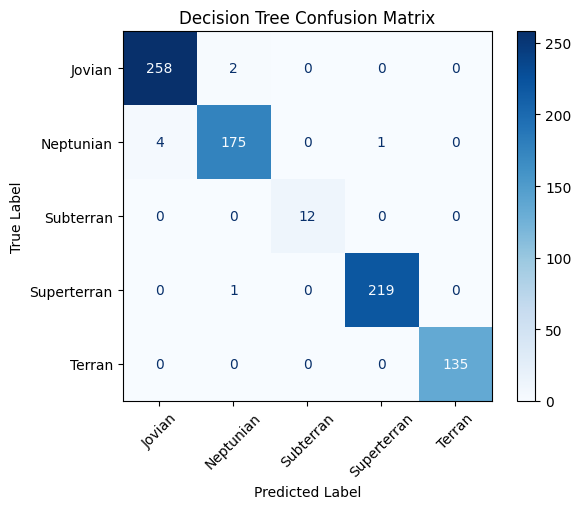

In [334]:
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

The metrics are notably better than those from the logistic regression model, especially for Subterrans. Perhaps decision trees are better suited for multiclass classification, even with little data.

Permutation is once again used to discover feature importance.

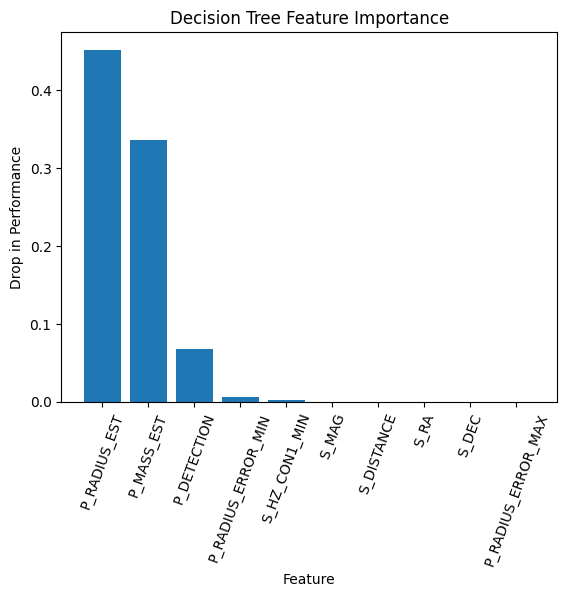

In [335]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
dec_tree = best_model.named_steps["dec_tree"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()
clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Calculate importances
importances = permutation_importance(dec_tree, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)

plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

In comparison to the logistic regression model, mass in a decision tree is a more significant predictor of exoplanet type.

## Random Forest

Now, a random forest model will be trained.

The pipeline is created and hyperparameter tuning is implemented, testing ranges of values for the major hyperparameters.

In [336]:
forest_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("rand_for", RandomForestClassifier())
])

param_dist = {
    "rand_for__n_estimators": [200, 400, 600, 800],
    "rand_for__max_depth": [None, 5, 10, 20, 40],
    "rand_for__min_samples_split": [2, 5, 10, 20],
    "rand_for__min_samples_leaf": [1, 2, 5, 10],
    "rand_for__max_features": ["sqrt", "log2", None],
    "rand_for__bootstrap": [True, False],
}

search = RandomizedSearchCV(forest_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained and hyperparameter values are shown.

In [337]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

n_estimators : 600
min_samples_split : 5
min_samples_leaf : 2
max_features : None
max_depth : 40
bootstrap : True


The model is tested and evaluated.

In [338]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

'              precision    recall  f1-score   support\n\n      Jovian       0.98      0.99      0.99       260\n   Neptunian       0.98      0.97      0.98       180\n   Subterran       1.00      1.00      1.00        12\n Superterran       1.00      1.00      1.00       220\n      Terran       1.00      1.00      1.00       135\n\n    accuracy                           0.99       807\n   macro avg       0.99      0.99      0.99       807\nweighted avg       0.99      0.99      0.99       807\n'

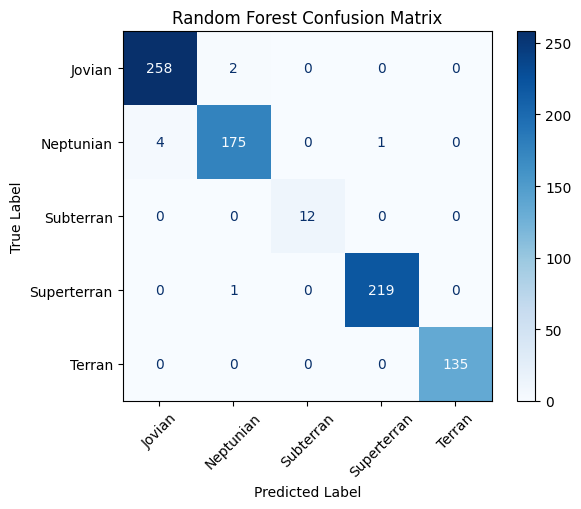

In [339]:
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

The metrics are around the same as those for the decision tree model. However, it takes much longer to fit, making random forests apparently unnecessary for this task.

Permutation is once again used to discover feature importance.

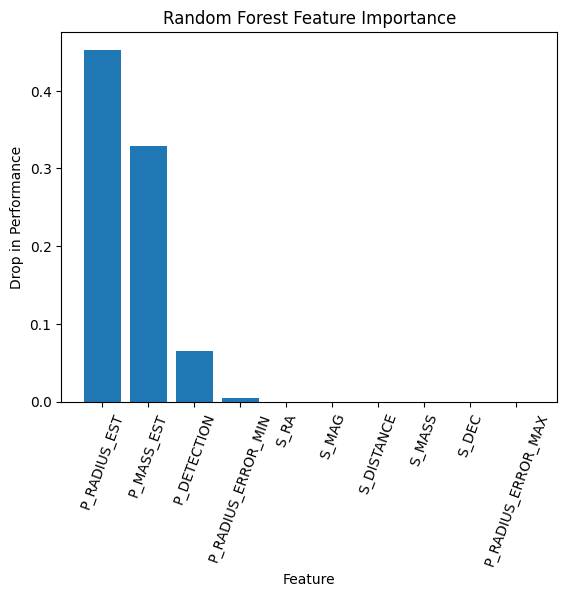

In [340]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
rand_for = best_model.named_steps["rand_for"]

# Run permutation importance
importances = permutation_importance(rand_for, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)

plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

The results are similar to those from the decision tree model.

This concludes the development of the classfication models.

# Exoplanet Mass Prediction

Now, regression models will be created to predict exoplanet mass.

## Ridge Regression

A simple linear regression model is a good starting point. Specifically, Ridge will be chosen over standard linear regression to be able to use regularization.

The data is split into the features and the target.

In [341]:
X = log_df.drop("Log_Mass", axis=1)
y = log_df["Log_Mass"]

The data is split into the training and testing data.

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

The transformers used for the logistic regression model can be reused.

In [343]:
# Separate numerical and categorical features
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Combine transformers
ridge_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("linear_cat_transformer", linear_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [345]:
ridge_pipe = Pipeline([
    ("ridge_preprocessor", ridge_preprocessor),
    ("ridge", Ridge())
])

kf = KFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "ridge__alpha": np.logspace(-4, 4)
}

search = RandomizedSearchCV(ridge_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf,
                            random_state=9, n_jobs=-1)

The model is trained and the optimized alpha value is displayed.

In [346]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

print("alpha:", f"{search.best_params_["ridge__alpha"]:.3f}")

alpha: 1526.418


RMSE and MAE are used to evaluate the model.

In [347]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

MAE factor  : 3.66×
RMSE factor : 45010330.47×


The results aren't promising. To understand why, the array of predicted values is analyzed along with the true values.

In [348]:
y_pred_se = pd.Series(y_pred)

y_pred_se.describe()

,0
count,807.000000
mean,1.562995
std,7.763020
min,0.260055
25%,0.719682
50%,0.946642
75%,2.010783
max,220.658874


In [349]:
y_test_se = y_test.reset_index(drop=True)

y_test_se.describe()

,Log_Mass
count,807.000000
mean,1.260273
std,1.007618
min,-1.719657
25%,0.578587
50%,0.874435
75%,2.090880
max,3.884029


There appears to be a major outlier present in the predicted values. This is further visible in a scatter plot of the actual and predicted values.

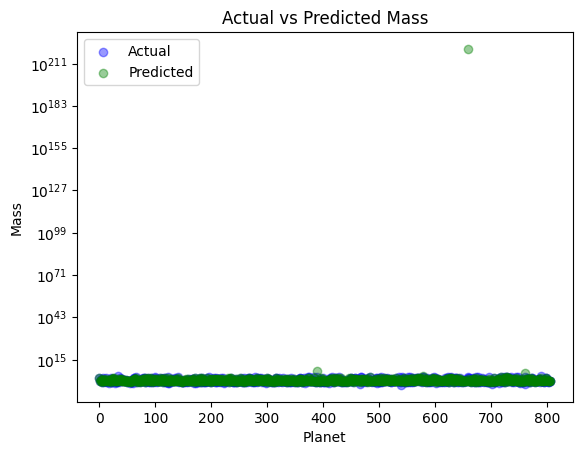

In [350]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

It appears that one heavily inacurate prediction is causing the metrics to significantly worsen. Therefore, linear regression doesn't seem to be a good model for this task.

## Polynomial Ridge Regression

Perhaps adding polynomial features will improve the results.

A polynomial transformer is created.

In [351]:
# Create polynomial transformer
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler())
])

# Combine transformers
poly_ridge_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("linear_cat_transformer", linear_cat_transformer, cat_col_names)
])

The pipeline is created and the alpha value along with the polynomial degree are tuned.

In [352]:
poly_ridge_pipe = Pipeline([
    ("poly_ridge_preprocessor", poly_ridge_preprocessor),
    ("ridge", Ridge())
])

param_dist = {
    "poly_ridge_preprocessor__poly_transformer__poly__degree" : [2, 3],
    "ridge__alpha" : np.logspace(-4, 4)
}

search = RandomizedSearchCV(poly_ridge_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf,
                            random_state=9, n_jobs=-1)

The model is trained and the hyperparameter values are shown.

In [353]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

print("alpha:", f"{search.best_params_["ridge__alpha"]:.3f}")
print("Degree:", f"{search.best_params_["poly_ridge_preprocessor__poly_transformer__poly__degree"]:.3f}")

alpha: 3237.458
Degree: 2.000
alpha: 3237.458
Degree: 2.000


RMSE and MAE are used to evaluate the model.

In [354]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

MAE factor  : 90100003.22×
RMSE factor : 785605796452345664379290322034733201129824937865441569220040608656447361036159426672534914858169593742575526999555941049148796095045396546903943169114604559826963869042785960187408316050036693633393212204655803629568.00×


The results are even worse than without polynomial features. In fact, the model is almost comically bad. The predicted values are again analyzed to learn why.

In [355]:
y_pred_se = pd.Series(y_pred)

y_pred_se.describe()

,0
count,807.000000
mean,-6.410771
std,215.808964
min,-6128.851052
25%,0.640829
50%,0.910099
75%,2.108988
max,6.474707


In [356]:
y_test_se.describe()

,Log_Mass
count,807.000000
mean,1.260273
std,1.007618
min,-1.719657
25%,0.578587
50%,0.874435
75%,2.090880
max,3.884029


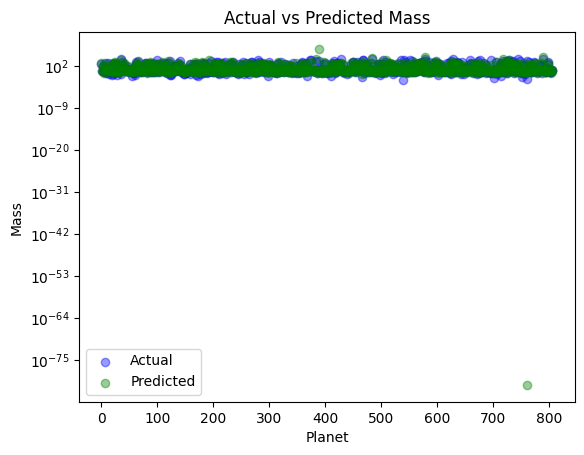

In [357]:
plt.scatter(x=range(0, len(y_test)), y=10**y_test.reset_index(drop=True), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

As before, there is a single inacurate value bringing the model down. With or without polynomial features, linear regression is unuseable.

## Decision Tree Regressor

Now, a decision tree is created, hopefully bearing better results.

A suitable pipeline is created and important hyperparameters are tuned.

In [358]:
# Combine numerical and categorical transformers
tree_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("tree_cat_transformer", tree_cat_transformer, cat_col_names)
])

tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeRegressor())
])

param_dist = {
    "dec_tree__max_depth": [None, 3, 5, 10, 20],
    "dec_tree__min_samples_split": [2, 5, 10, 20, 50],
    "dec_tree__min_samples_leaf": [1, 2, 5, 10, 20, 50],
    "dec_tree__max_features": [None, "sqrt", "log2"]
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained and hyperparameter values are displayed.

In [359]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

min_samples_split : 50
min_samples_leaf : 2
max_features : None
max_depth : 20


As before, RMSE and MAE are used to evaluate the model.

In [360]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

MAE factor  : 1.24×
RMSE factor : 1.67×


The results point to a strong model. Real exoplanet masses often have 30-100% observational uncertainty, so a 24% error factor is very good. This is also evident in a scatter plot.

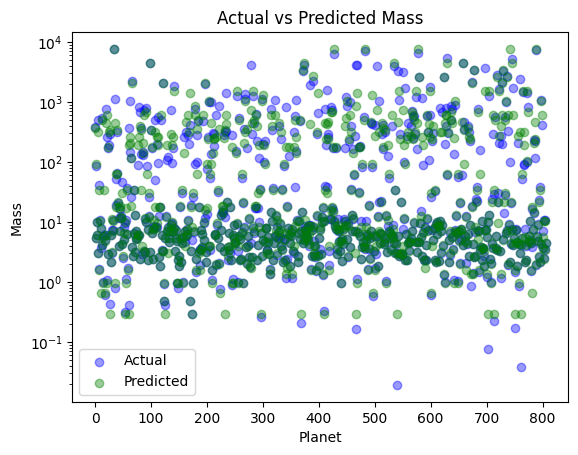

In [361]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

Permutation is used to find important features.

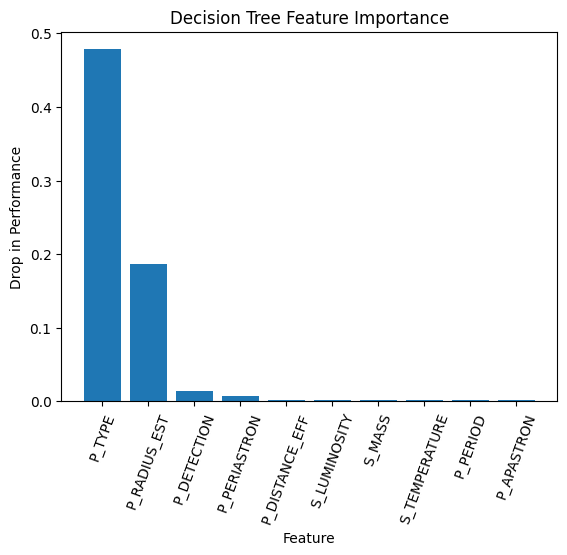

In [362]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
dec_tree = best_model.named_steps["dec_tree"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()
clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(dec_tree, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)

plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

By far the most important features are the planet's type and radius. These findings make sense; mass and radius are often correlated and a Jovian planet will certainly have a greater mass than a Terran one.

## Random Forest Regressor

Perhaps a random forest will be even better for prediction.

As usual, the pipeline is created and hyperparameter tuning is implemented.

In [363]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("rand_for", RandomForestRegressor())
])

param_dist = {
    "rand_for__n_estimators": [200, 300, 500, 800],
    "rand_for__max_depth": [None, 5, 10, 20, 40],
    "rand_for__min_samples_split": [2, 5, 10, 20],
    "rand_for__min_samples_leaf": [1, 2, 5, 10, 20],
    "rand_for__max_features": ["sqrt", "log2", None],
    "rand_for__bootstrap": [True, False]
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

Again, the model is trained and tuned hyperparameter values are shown.

In [364]:
search.fit(X_train, y_train)

best_model = search.best_estimator_

for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

n_estimators : 300
min_samples_split : 20
min_samples_leaf : 2
max_features : None
max_depth : 40
bootstrap : True


RMSE and MAE are used to evaluate the model as usual.

In [365]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

MAE factor  : 1.20×
RMSE factor : 1.57×


The model performs slightly better than the decision tree model, but takes much more time to train. These results are similar to those from the classification tree models.

A plot is generated as before to underscore these findings.

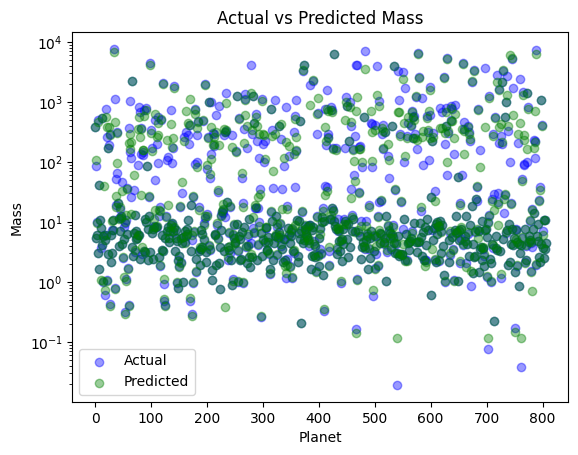

In [366]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

The predicted and actual values are relatively close together, implying little erorr in prediction.

Feature importance is analyzed.

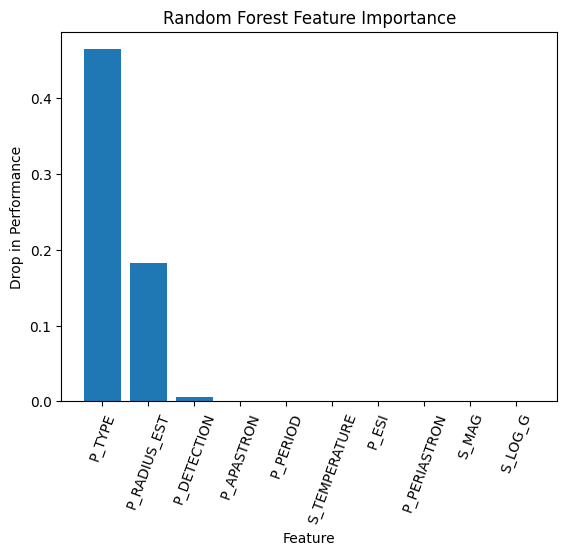

In [367]:
# Extract components
rand_for = best_model.named_steps["rand_for"]

# Run permutation importance on the classifier only
importances = permutation_importance(rand_for, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)
# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)

plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

The results are similar to those from the decision tree model.

# Conclusion

To conclude, significant insights can be drawn from this analysis. Firstly, decision trees seem to be the all-around best models for both classification of exoplanet type and of mass. Random forests produce slightly better results, but take longer to train. They may have out-performed linear models due to not being restricted to following a linear strcture. Additionally, the most important features for classifying exoplanets were its radius and mass. The most important features for predicting a planet's mass were its type and radius. Therefore, exoplanet type, radius and mass seem to be highly correlated.

# Copyright

The data used in this project was taken from the exoplanet catalog found here: https://www.kaggle.com/datasets/chandrimad31/phl-exoplanet-catalog?resource=download.

I claim no ownership of the data. All rights reserved to the rightful owners.